# Panel Fixed Effects Regression

This notebook demonstrates panel regression with fixed effects using CausalPy. Panel data methods are foundational in applied econometrics and causal inference, particularly when dealing with unobserved time-invariant confounders.

## What You'll Learn

- What panel data is and why it's useful for causal inference
- How fixed effects control for unobserved heterogeneity  
- Two approaches: dummy variables vs within transformation
- When to use each approach
- Panel-specific visualizations and diagnostics

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import causalpy as cp

warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("default")

## Introduction to Panel Data

**Panel data** (also called longitudinal data) consists of observations on multiple units (individuals, firms, countries, etc.) observed over multiple time periods.

### The Problem: Omitted Variable Bias

Consider studying the effect of training on worker productivity:
- $y_{it}$ = productivity of worker $i$ at time $t$
- $X_{it}$ = 1 if worker received training, 0 otherwise
- $\alpha_i$ = innate ability of worker $i$ (unobserved!)

Problem: More able workers might self-select into training! Naive OLS will be biased.

### The Solution: Fixed Effects

Fixed effects estimation removes all time-invariant unit characteristics ($\alpha_i$), eliminating bias from unobserved confounders that don't change over time.

**Model:**

$$y_{it} = \beta_0 + \beta_1 X_{it} + \alpha_i + \epsilon_{it}$$

**Two equivalent approaches:**
1. **Dummy variables**: Include a dummy for each unit
2. **Within transformation**: Subtract unit-specific means from all variables

## Example 1: Simulated Data with Known Ground Truth

Let's simulate panel data where we know the true treatment effect.

In [2]:
# Set random seed
np.random.seed(42)

# Panel dimensions
n_units = 20
n_periods = 15
treatment_time = 10

# True parameters
TRUE_TREATMENT_EFFECT = 3.0
TRUE_X_COEF = 0.5

# Generate panel data
data = []
for i in range(n_units):
    unit_effect = np.random.randn() * 2.0

    for t in range(n_periods):
        x1 = np.random.randn()
        treatment = 1 if (t >= treatment_time and i < n_units // 2) else 0

        y = (
            unit_effect
            + TRUE_TREATMENT_EFFECT * treatment
            + TRUE_X_COEF * x1
            + np.random.randn() * 0.5
        )

        data.append(
            {
                "unit": f"unit_{i}",
                "time": t,
                "treatment": treatment,
                "x1": x1,
                "y": y,
            }
        )

df_sim = pd.DataFrame(data)
print(f"Panel: {n_units} units, {n_periods} periods")
print(f"True treatment effect: {TRUE_TREATMENT_EFFECT}")
df_sim.head()

Panel: 20 units, 15 periods
True treatment effect: 3.0


,unit,time,treatment,x1,y
0,unit_0,0,0,-0.138264,1.248140
1,unit_0,1,0,1.523030,1.637867
2,unit_0,2,0,-0.234137,1.665966
3,unit_0,3,0,0.767435,1.142408
4,unit_0,4,0,0.542560,1.032999


### Naive OLS (Biased)

First, let's see what happens if we ignore the unit fixed effects:

In [3]:
# Naive OLS without fixed effects
X_naive = df_sim[["treatment", "x1"]].values
y_naive = df_sim["y"].values

naive_model = LinearRegression().fit(X_naive, y_naive)
print("Naive OLS (NO fixed effects):")
print(f"  Treatment effect: {naive_model.coef_[0]:.3f} (True: {TRUE_TREATMENT_EFFECT})")
print(f"  Bias: {naive_model.coef_[0] - TRUE_TREATMENT_EFFECT:.3f}")

Naive OLS (NO fixed effects):
  Treatment effect: 3.219 (True: 3.0)
  Bias: 0.219


### Fixed Effects with Dummies

In [4]:
# Panel regression with dummy variables
result_dummies = cp.PanelRegression(
    data=df_sim,
    formula="y ~ C(unit) + treatment + x1",
    unit_fe_variable="unit",
    fe_method="dummies",
    model=LinearRegression(),
)

treatment_idx = result_dummies.labels.index("treatment")
treatment_coef = result_dummies.model.coef_[treatment_idx]

print("Fixed Effects (Dummies):")
print(f"  Treatment effect: {treatment_coef:.3f} (True: {TRUE_TREATMENT_EFFECT})")
print(f"  Bias: {treatment_coef - TRUE_TREATMENT_EFFECT:.3f}")

result_dummies.summary()

Fixed Effects (Dummies):
  Treatment effect: 3.106 (True: 3.0)
  Bias: 0.106

Panel Regression
Units: 20 (unit)
FE method: dummies
Observations: 300

Note: 19 fixed effect coefficients not shown (use print_coefficients() to see all)

Model Coefficients (excluding FE dummies):
Model coefficients:
  Intercept	      0.83
  treatment	       2.7
  x1       	      -1.2


### Fixed Effects with Within Transformation

The within transformation gives identical results:

In [5]:
# Panel regression with within transformation
result_within = cp.PanelRegression(
    data=df_sim,
    formula="y ~ treatment + x1",  # No C(unit) needed!
    unit_fe_variable="unit",
    fe_method="within",
    model=LinearRegression(),
)

treatment_idx = result_within.labels.index("treatment")
treatment_coef_within = result_within.model.coef_[treatment_idx]

print("Fixed Effects (Within):")
print(
    f"  Treatment effect: {treatment_coef_within:.3f} (True: {TRUE_TREATMENT_EFFECT})"
)
print(f"  Difference from dummies: {abs(treatment_coef - treatment_coef_within):.6f}")

Fixed Effects (Within):
  Treatment effect: 3.106 (True: 3.0)
  Difference from dummies: 0.000000


## Example 2: Small Panel — State Policy Analysis

For small panels (e.g., 50 US states), we can use the dummy variable approach.

In [6]:
# Simulate state-level data
np.random.seed(123)

n_states = 12
n_years = 10
policy_year = 5

state_data = []
for s in range(n_states):
    state_name = f"State_{chr(65 + s)}"
    state_baseline = np.random.randn() * 5 + 50

    for y in range(n_years):
        policy = 1 if (y >= policy_year and s < n_states // 2) else 0
        gdp_growth = np.random.randn() * 2

        outcome = (
            state_baseline
            + 0.3 * y
            + 5.0 * policy
            + 0.5 * gdp_growth
            + np.random.randn() * 1.5
        )

        state_data.append(
            {
                "state": state_name,
                "year": y,
                "policy": policy,
                "gdp_growth": gdp_growth,
                "outcome": outcome,
            }
        )

df_states = pd.DataFrame(state_data)
print(f"State panel: {n_states} states, {n_years} years")
df_states.head()

State panel: 12 states, 10 years


,state,year,policy,gdp_growth,outcome
0,State_A,0,0,1.994691,45.993660
1,State_A,1,0,-3.012589,42.497652
2,State_A,2,0,3.302873,43.183265
3,State_A,3,0,-0.857825,46.941839
4,State_A,4,0,-1.733481,43.886777


In [7]:
# Fit panel regression with state and year FE
result_states = cp.PanelRegression(
    data=df_states,
    formula="outcome ~ C(state) + C(year) + policy + gdp_growth",
    unit_fe_variable="state",
    time_fe_variable="year",
    fe_method="dummies",
    model=LinearRegression(),
)

result_states.summary()


Panel Regression
Units: 12 (state)
Periods: 10 (year)
FE method: dummies
Observations: 120

Note: 20 fixed effect coefficients not shown (use print_coefficients() to see all)

Model Coefficients (excluding FE dummies):
Model coefficients:
  Intercept 	        45
  policy    	        12
  gdp_growth	         4


### Visualizations

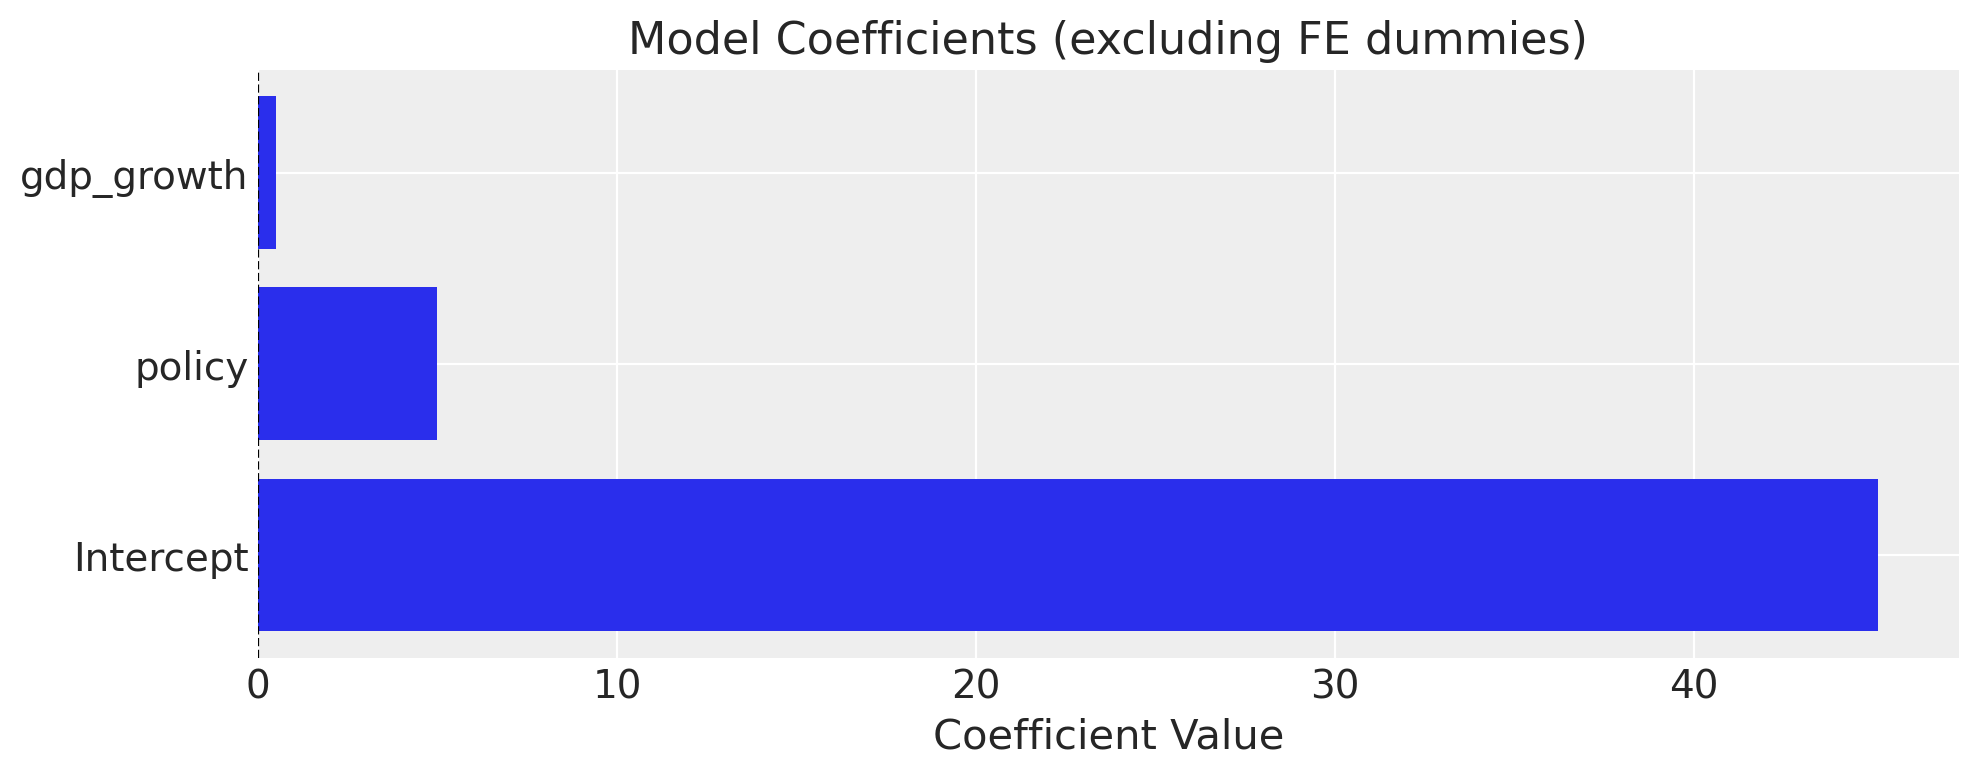

In [8]:
# Coefficient plot
fig, ax = result_states.plot_coefficients()
plt.tight_layout()
plt.show()

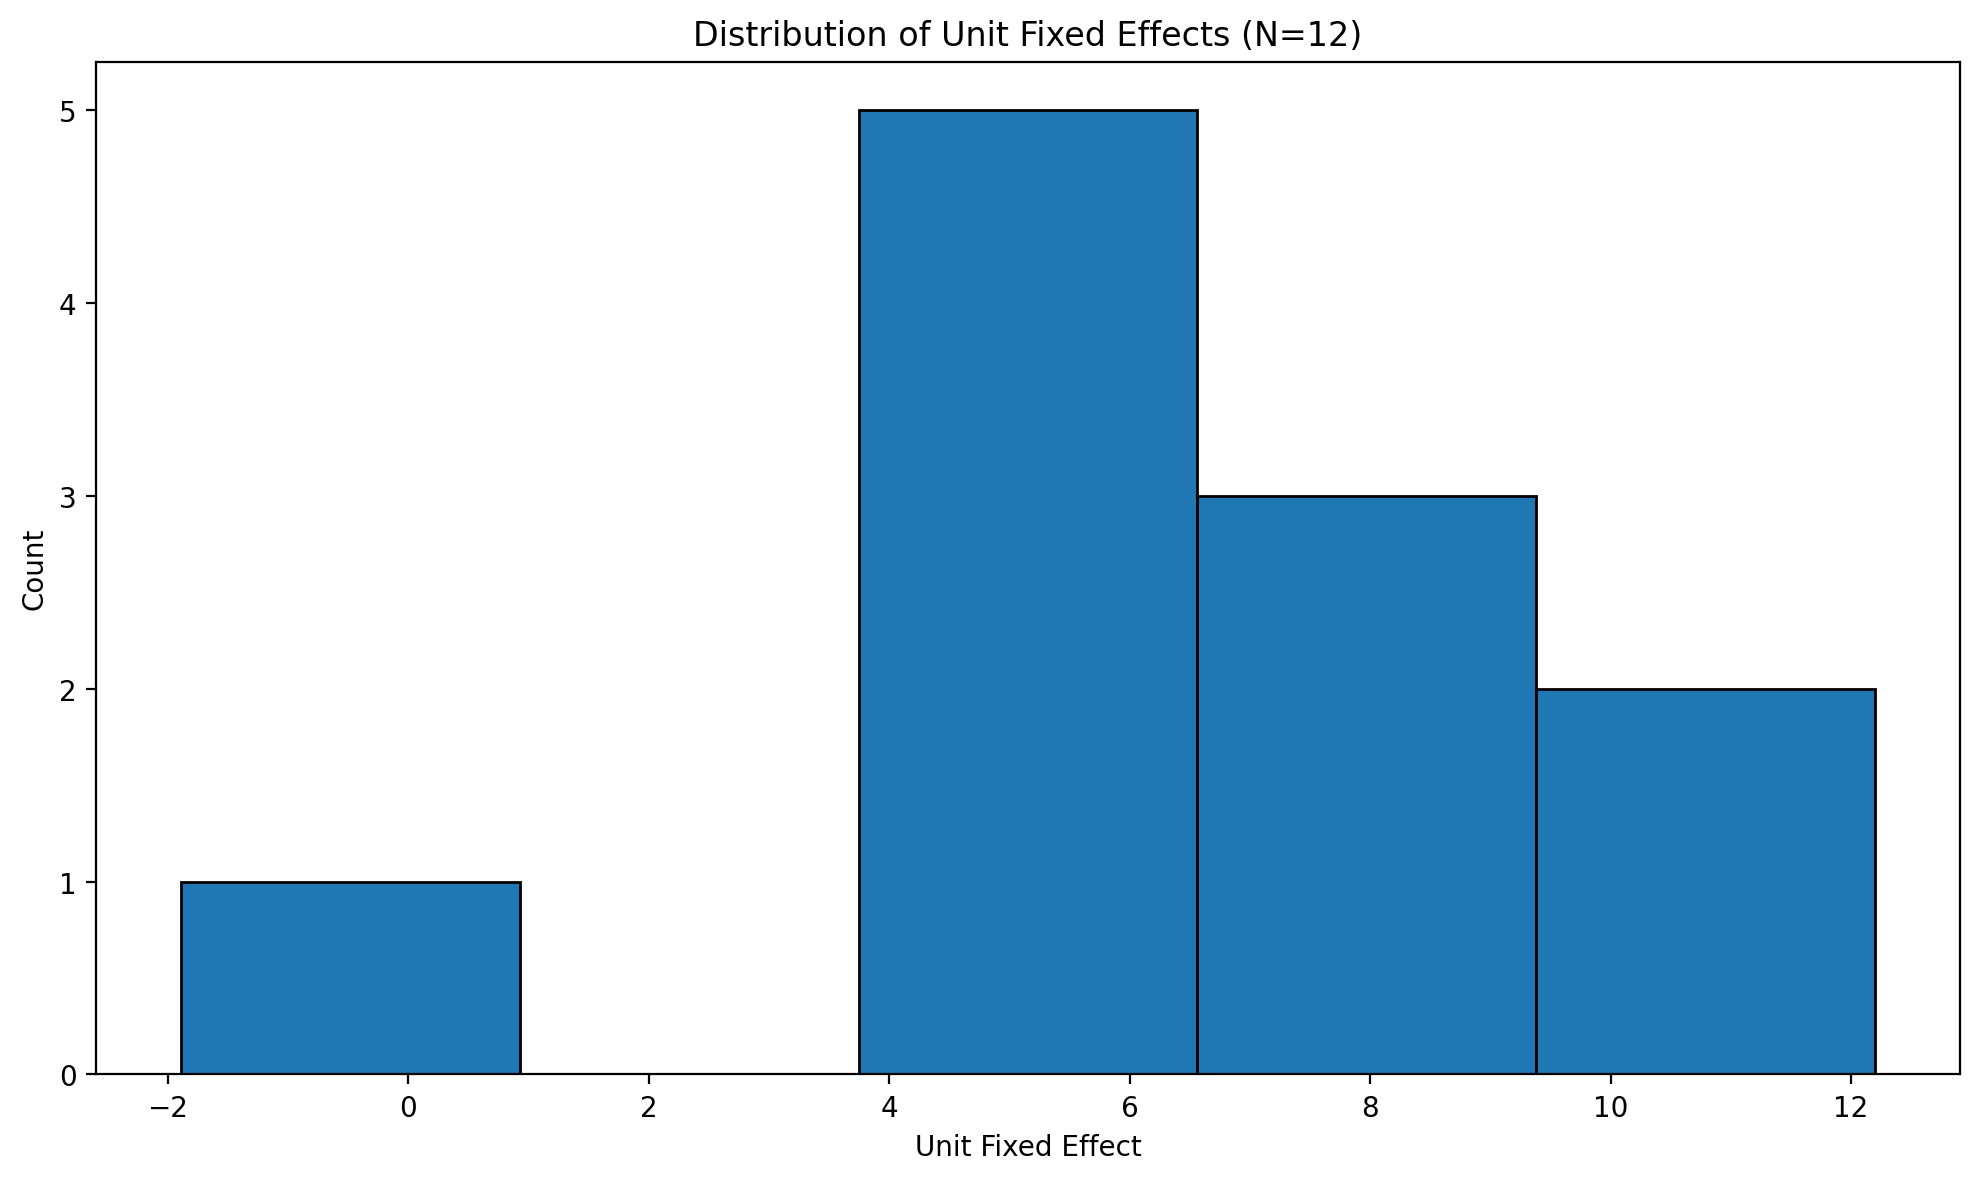

In [9]:
# Distribution of state fixed effects
fig, ax = result_states.plot_unit_effects()
plt.tight_layout()
plt.show()

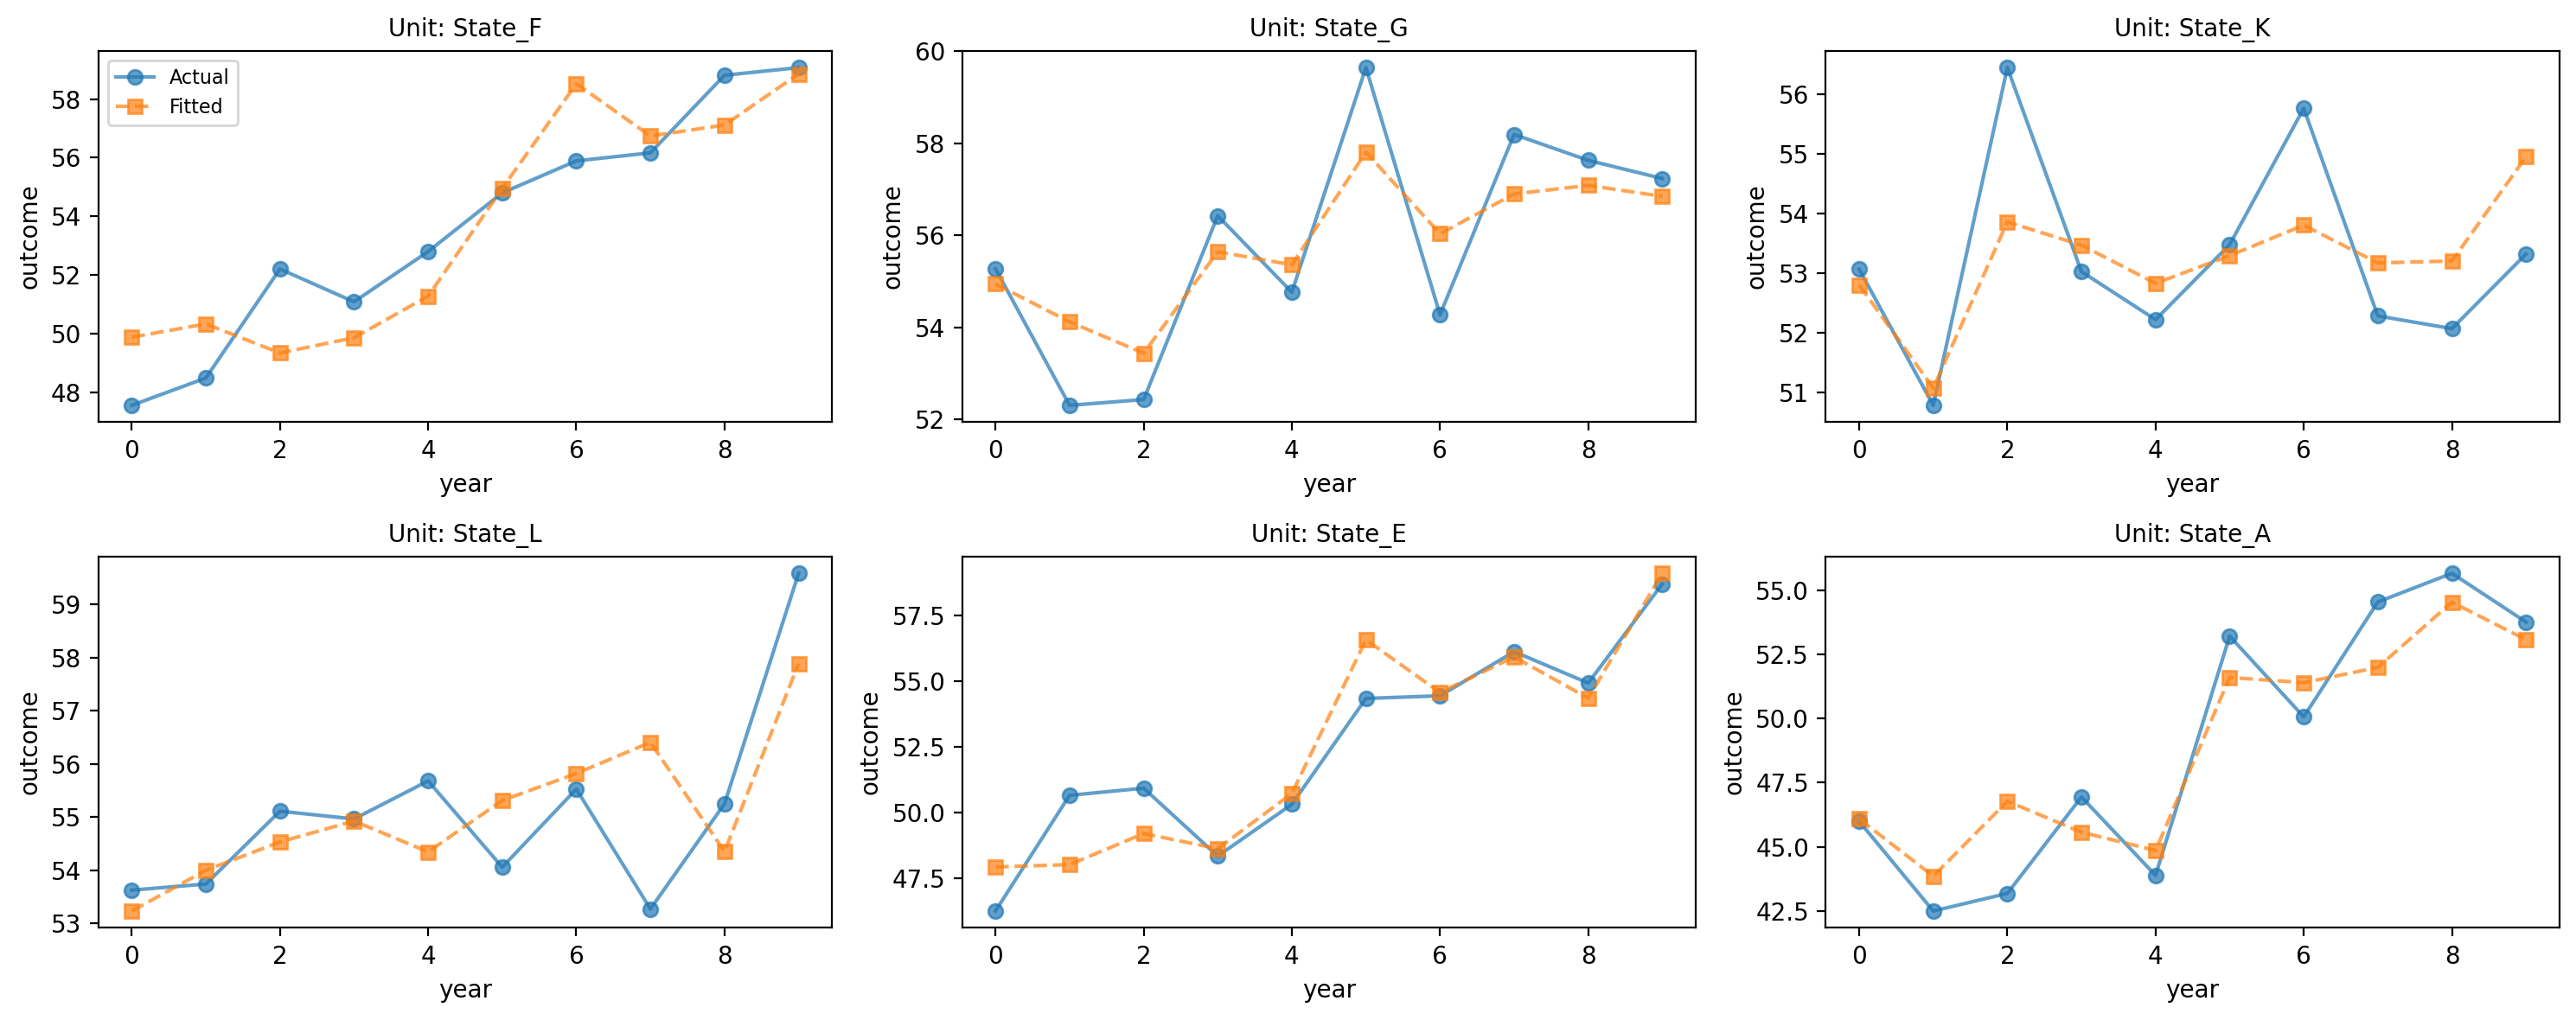

In [10]:
# State trajectories
fig, axes = result_states.plot_trajectories(n_sample=6)
plt.tight_layout()
plt.show()

## Example 3: Large Panel with Within Transformation

For large panels, the within transformation is more practical.

In [11]:
# Simulate worker panel
np.random.seed(456)

n_workers = 200
n_waves = 8
training_wave = 4

worker_data = []
for w in range(n_workers):
    worker_id = f"worker_{w:04d}"
    ability = np.random.randn() * 3

    for wave in range(n_waves):
        trained = 1 if (wave >= training_wave and w < n_workers * 0.4) else 0
        experience = wave * 0.5 + np.random.randn() * 0.2

        productivity = (
            ability + 2.5 * trained + 0.3 * experience + np.random.randn() * 0.8
        )

        worker_data.append(
            {
                "worker_id": worker_id,
                "wave": wave,
                "trained": trained,
                "experience": experience,
                "productivity": productivity,
            }
        )

df_workers = pd.DataFrame(worker_data)
print(f"Worker panel: {n_workers} workers, {n_waves} waves")
df_workers.head()

Worker panel: 200 workers, 8 waves


,worker_id,wave,trained,experience,productivity
0,worker_0000,0,0,-0.099642,-1.539417
1,worker_0000,1,0,0.613738,-0.739856
2,worker_0000,2,0,1.325918,-1.365037
3,worker_0000,3,0,1.589897,-1.804065
4,worker_0000,4,1,1.936954,-0.536076


In [12]:
# Within transformation (no dummies)
result_workers = cp.PanelRegression(
    data=df_workers,
    formula="productivity ~ trained + experience",
    unit_fe_variable="worker_id",
    time_fe_variable="wave",
    fe_method="within",
    model=LinearRegression(),
)

result_workers.summary()


Panel Regression
Units: 200 (worker_id)
Periods: 8 (wave)
FE method: within
Observations: 1600

Model Coefficients (excluding FE dummies):
Model coefficients:
  Intercept 	   1.8e-17
  trained   	       2.4
  experience	       0.2


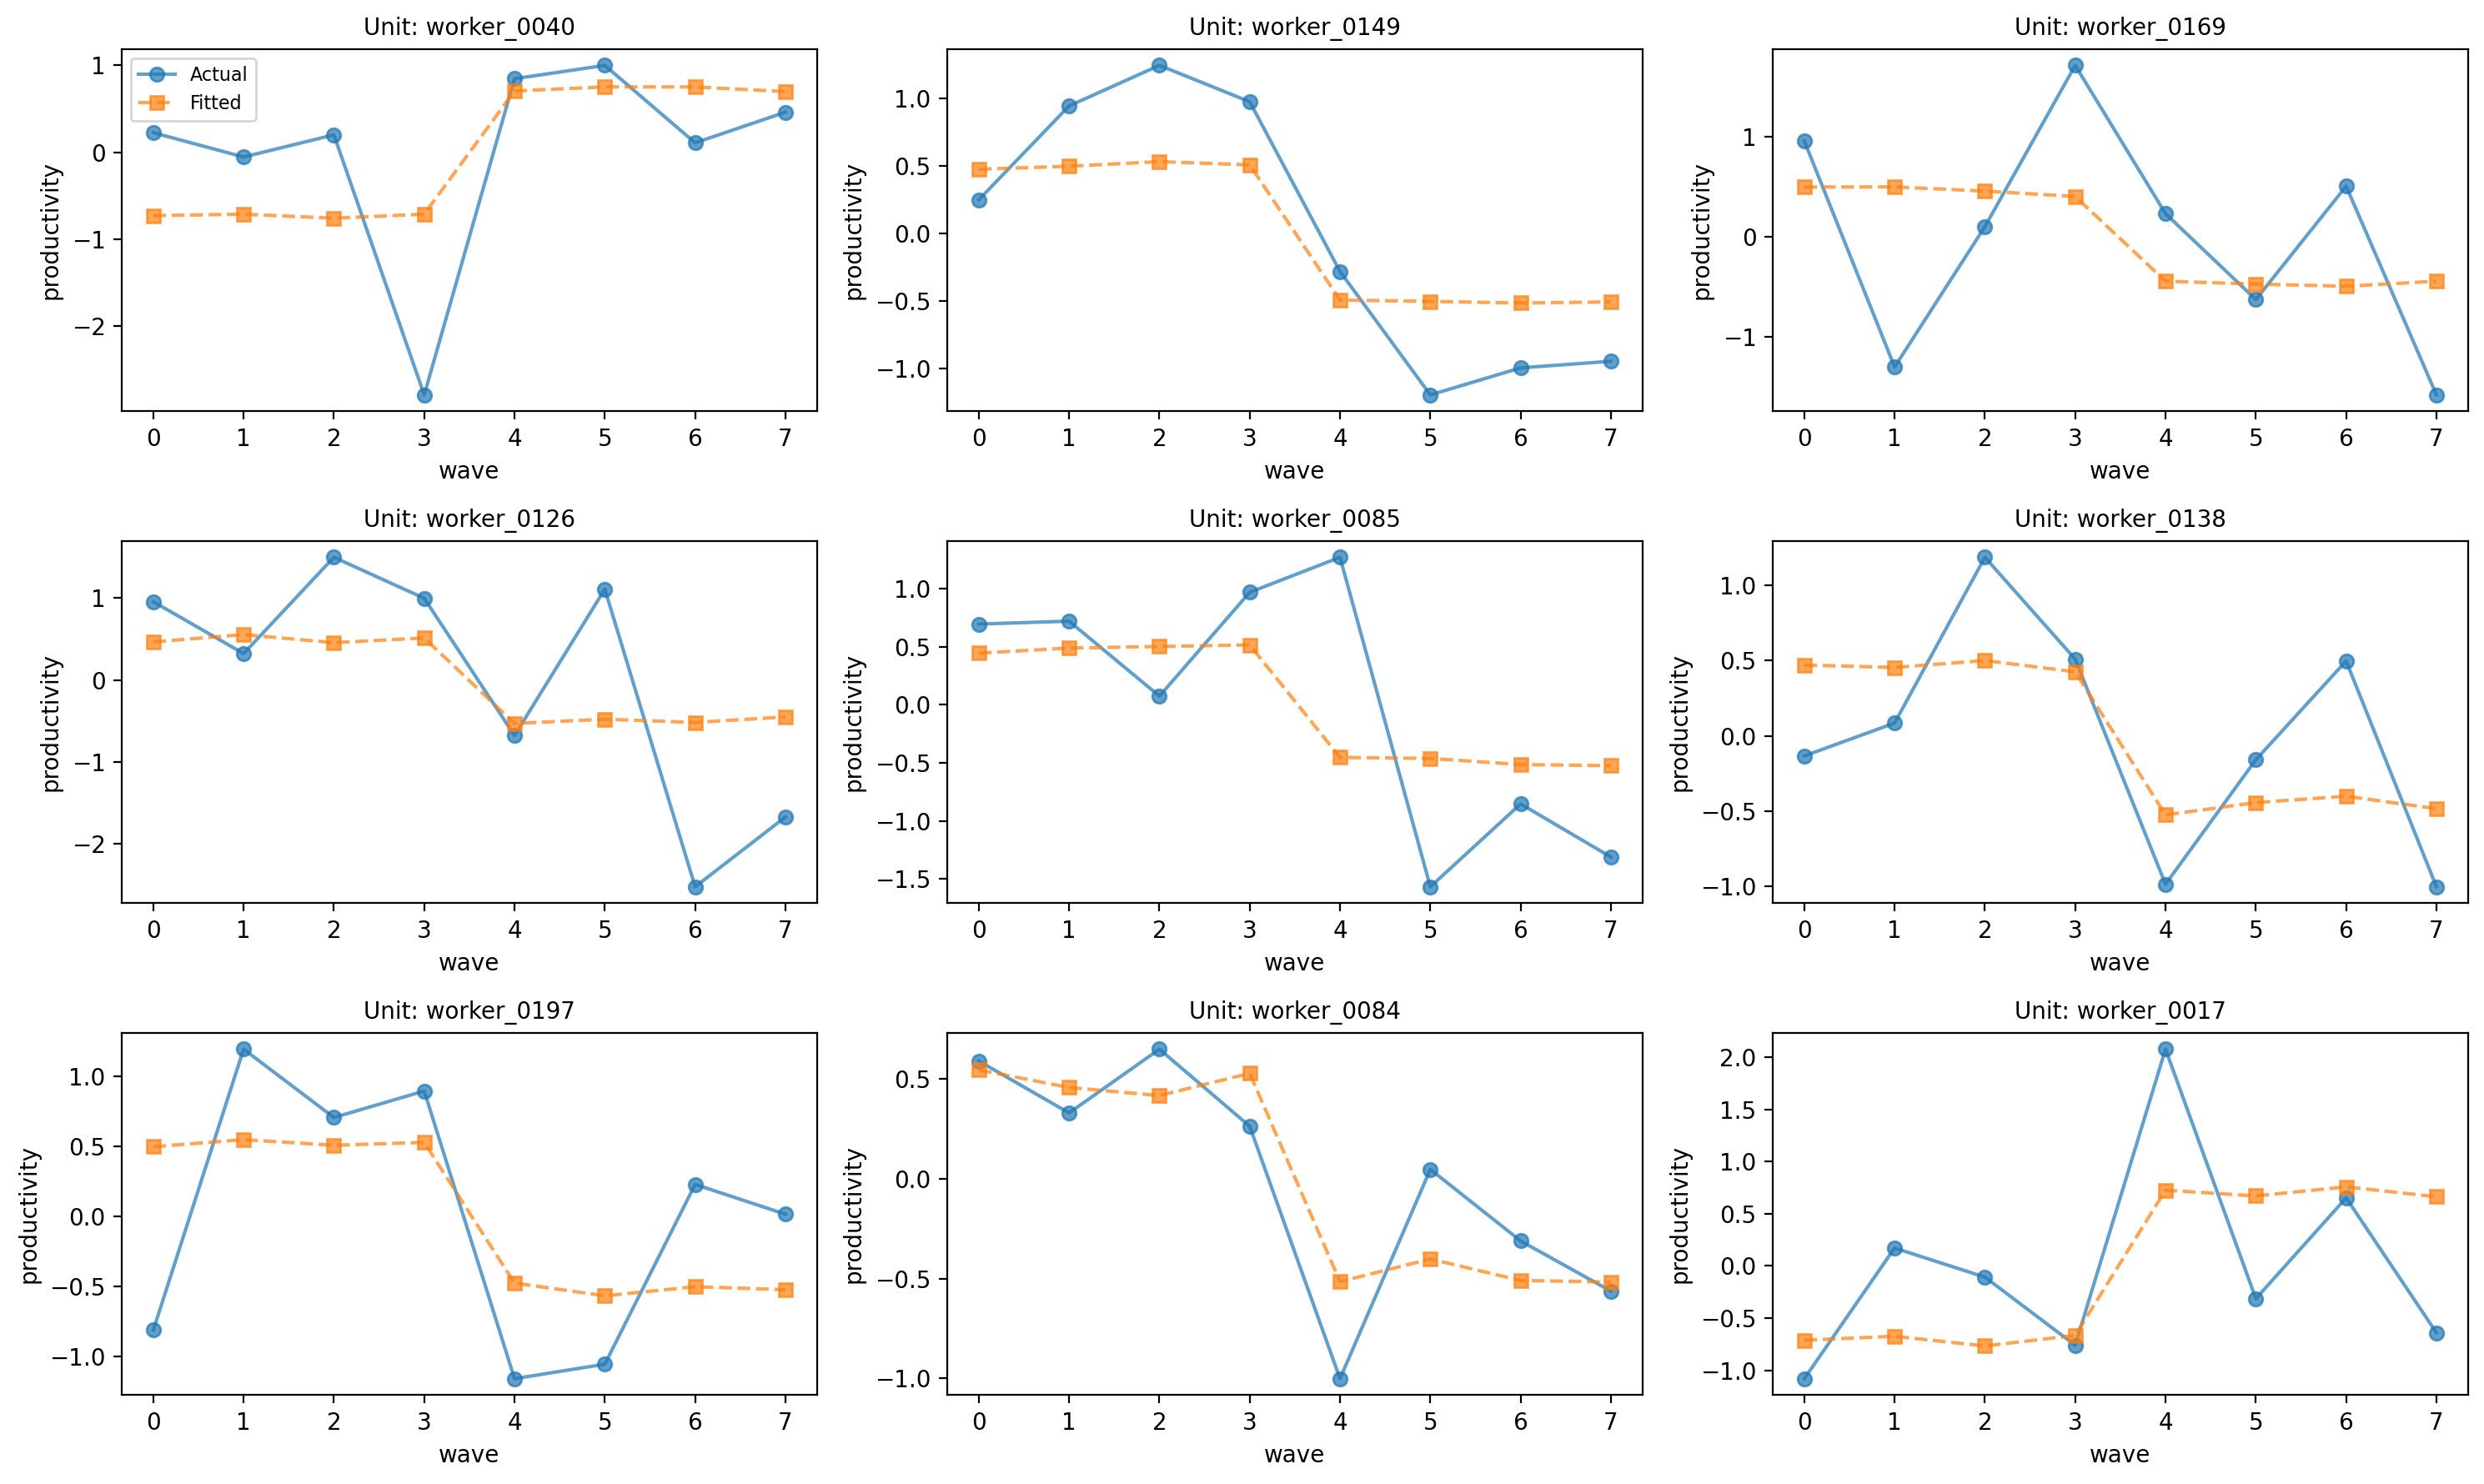

In [13]:
# Worker trajectories
fig, axes = result_workers.plot_trajectories(n_sample=9)
plt.tight_layout()
plt.show()

## Diagnostics

Always check model diagnostics!

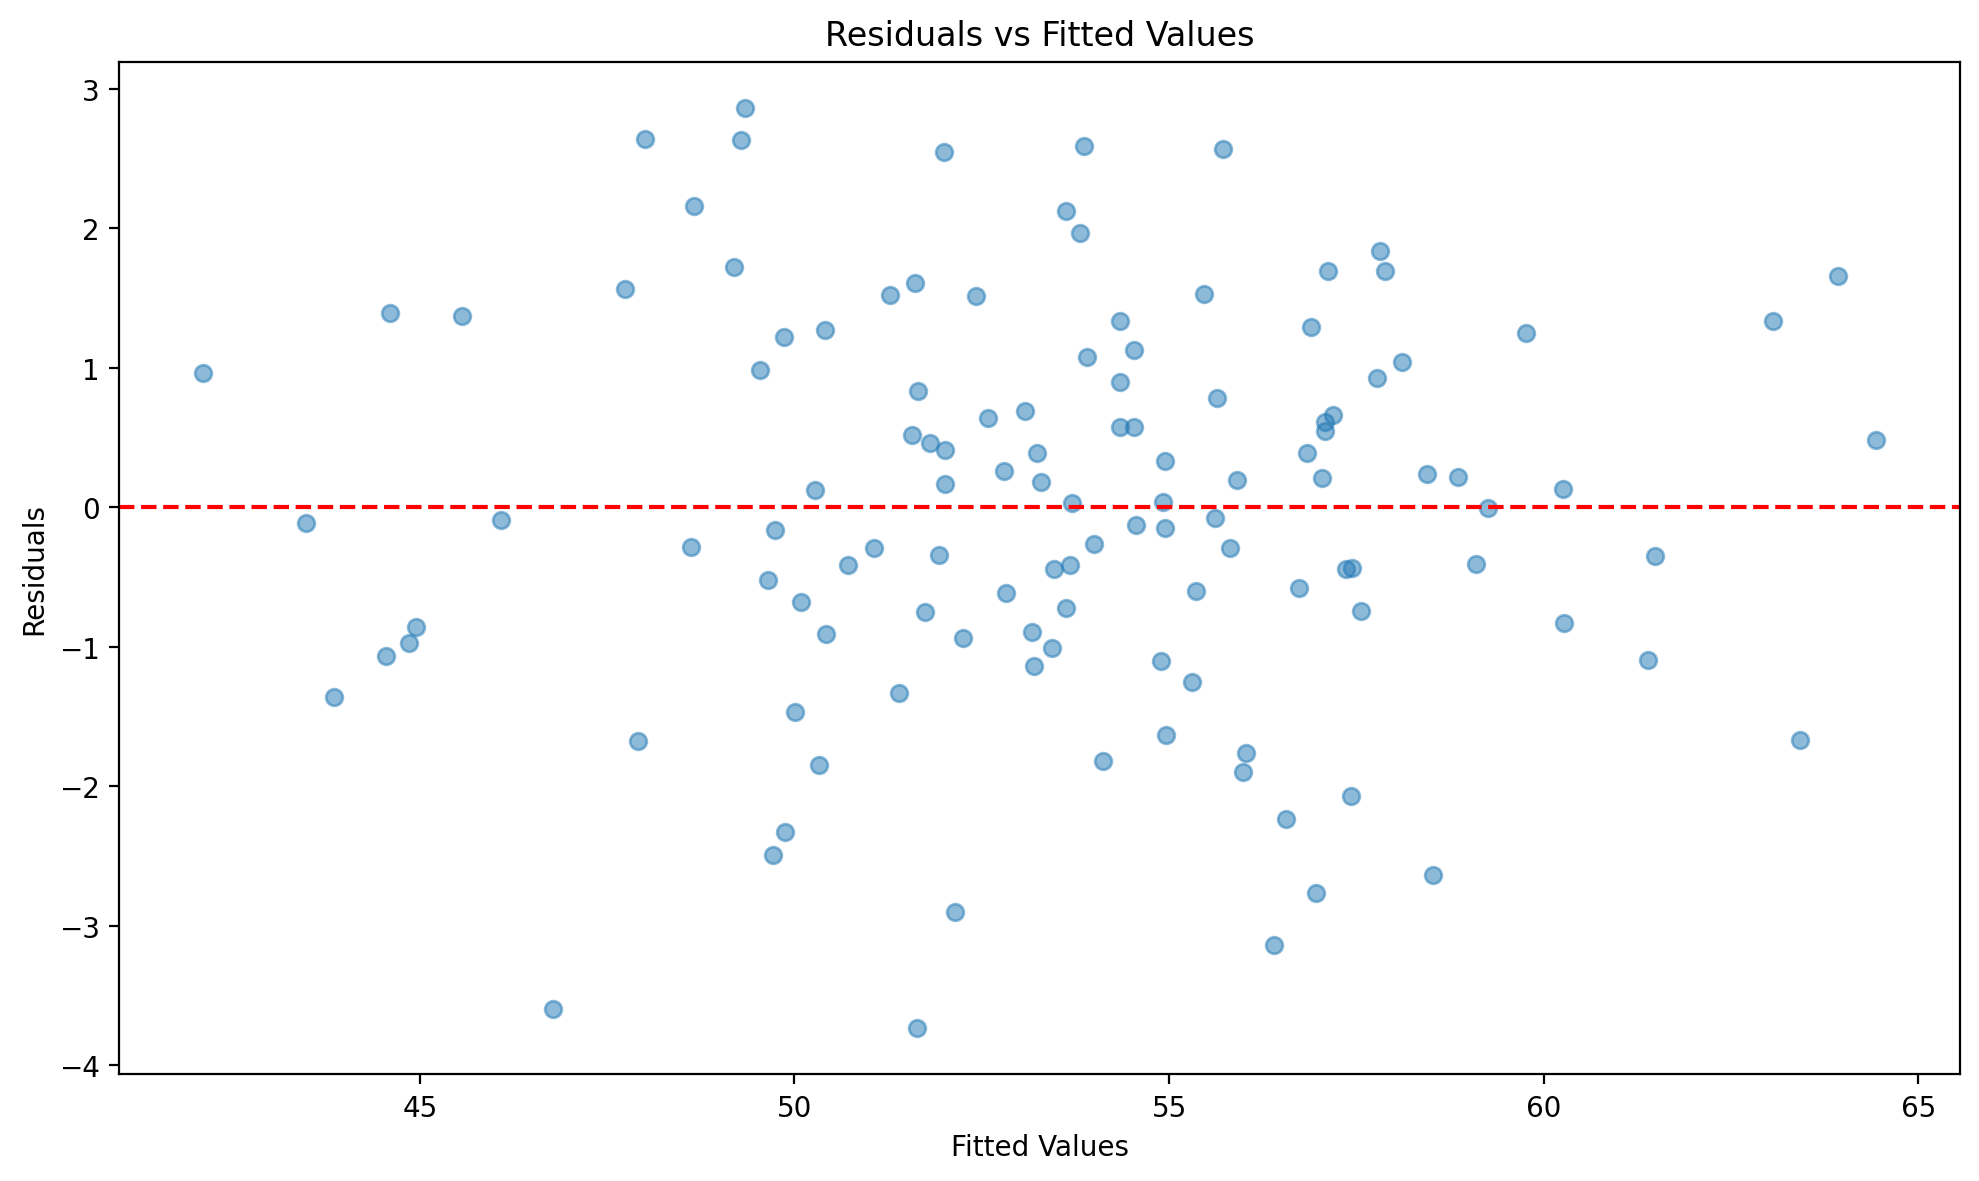

In [14]:
# Residuals vs fitted
fig, ax = result_states.plot_residuals(kind="scatter")
plt.tight_layout()
plt.show()

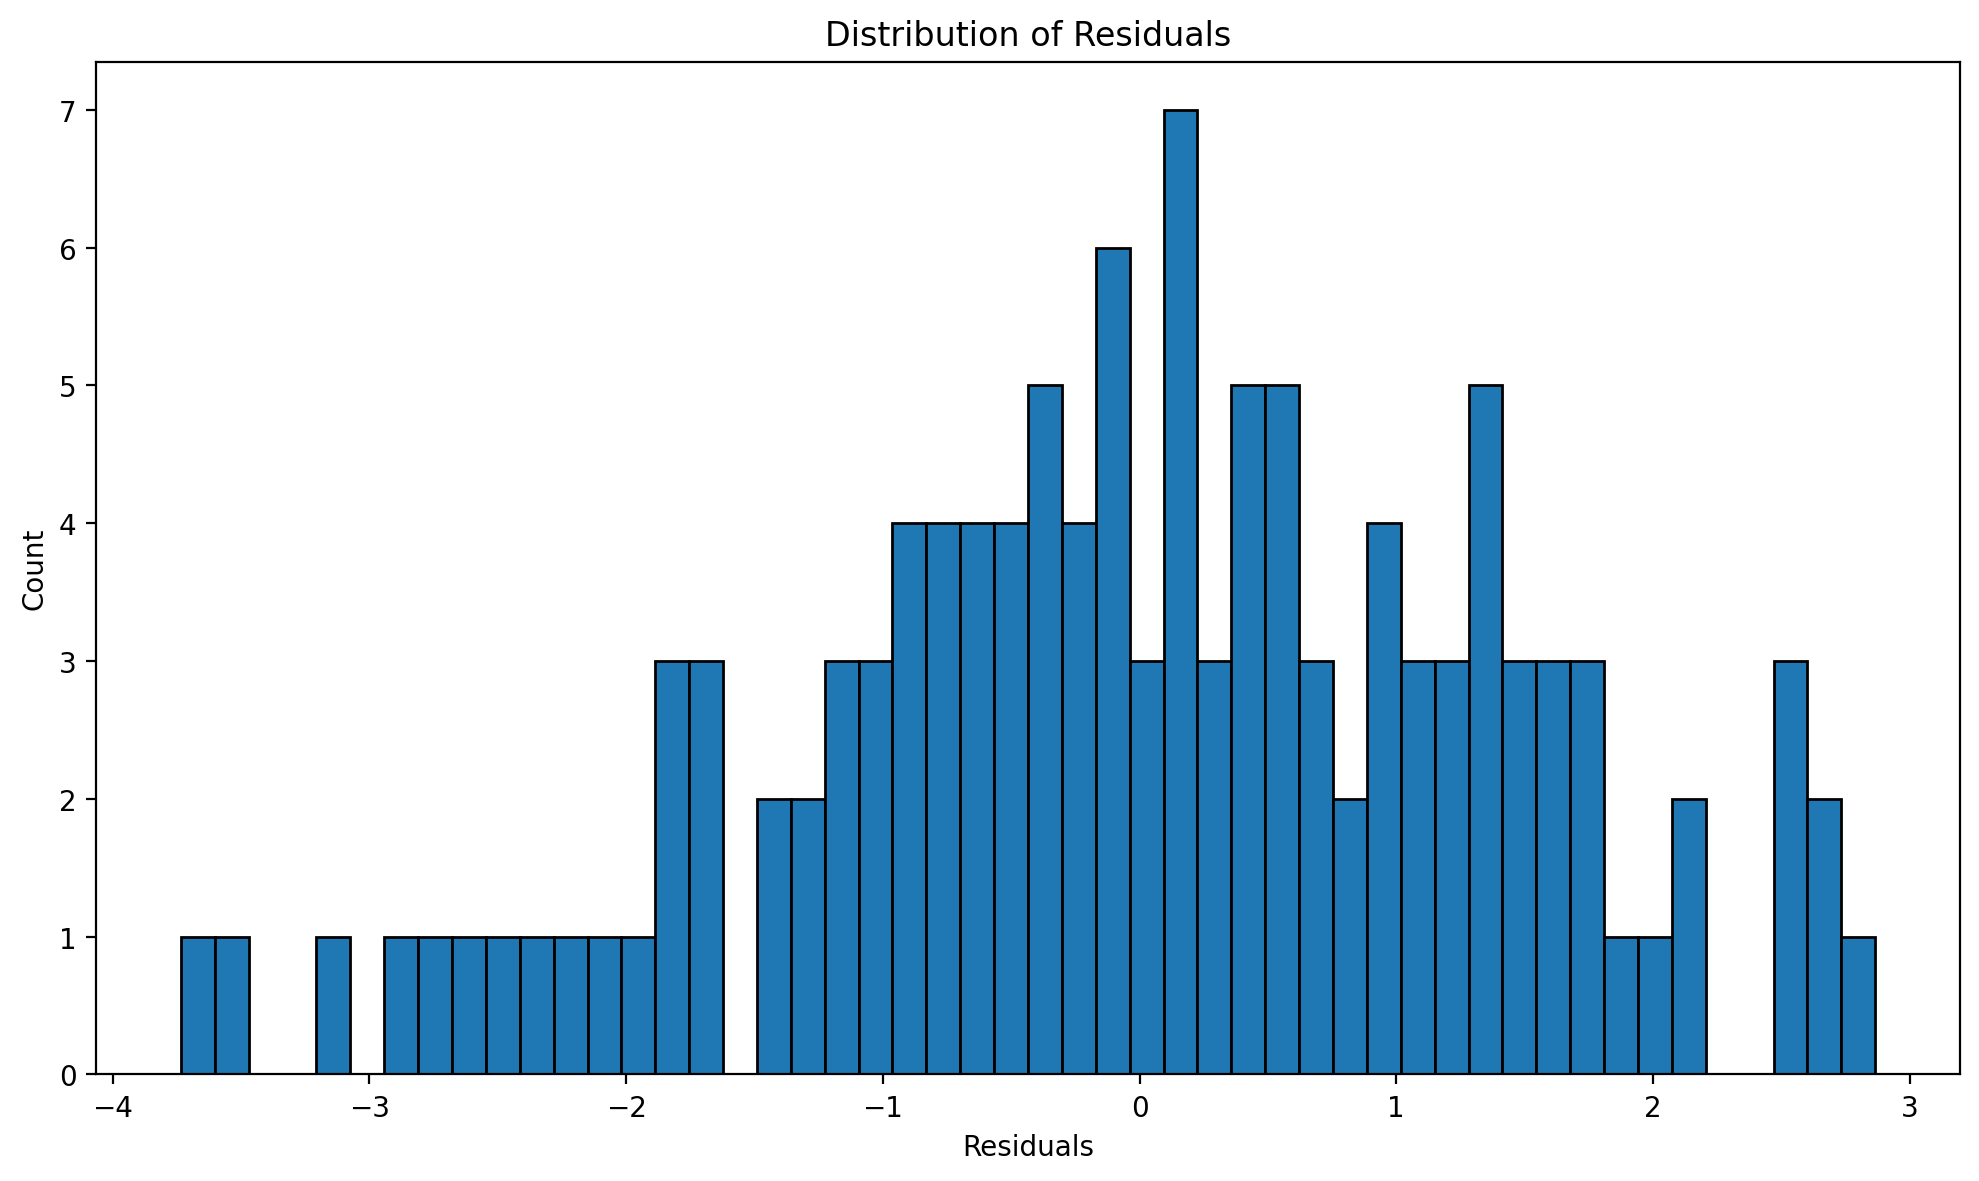

In [15]:
# Distribution of residuals
fig, ax = result_states.plot_residuals(kind="histogram")
plt.tight_layout()
plt.show()

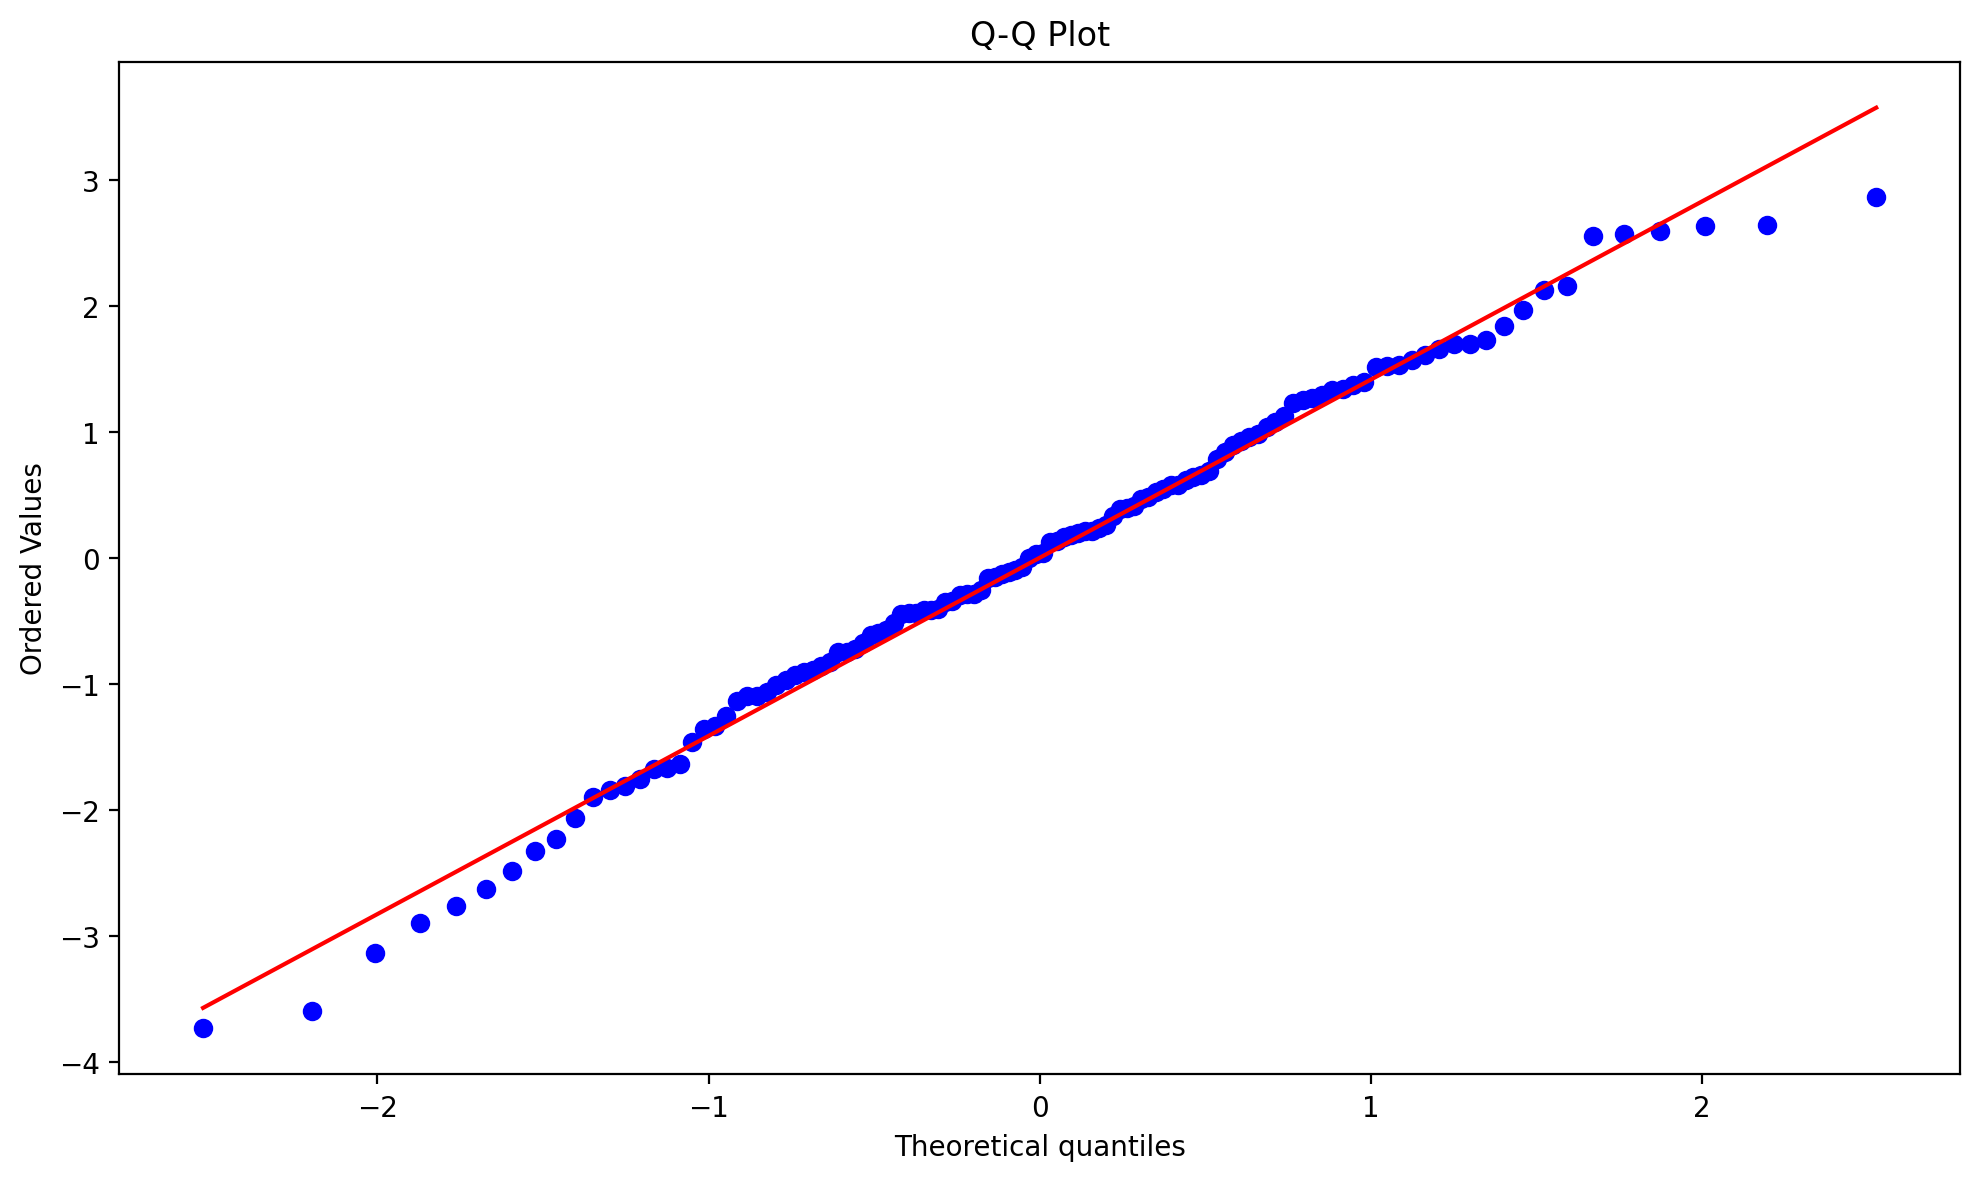

In [16]:
# Q-Q plot
fig, ax = result_states.plot_residuals(kind="qq")
plt.tight_layout()
plt.show()

## Summary

### When to Use Panel Fixed Effects

✅ **Use when:**
- You have repeated observations on the same units
- You suspect unobserved time-invariant confounders
- You have time-varying treatment/covariates

❌ **Don't use when:**
- You only have cross-sectional data
- Your treatment is time-invariant (within transformation will remove it!)

### Dummies vs Within

| Criterion | Dummies | Within |
|-----------|---------|--------|
| **When** | Small N (< 100) | Large N (100+) |
| **Pros** | Individual unit effects | Scales to large N |
| **Cons** | Doesn't scale | Can't estimate individual effects |
| **Formula** | `y ~ C(unit) + X` | `y ~ X` |

### Further Reading

- [Causal Inference: The Mixtape - Chapter 8](https://mixtape.scunning.com/08-panel_data)
- Wooldridge (2010): *Econometric Analysis of Cross Section and Panel Data*